In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
markov_network = np.array([[1, 0, -1, -1, -1],
                            [0, 1, 0.2, 0.2, 0.2],
                            [0, 0, 1, 0, 0],
                            [0, 0, 0, 0.5, 0],
                            [0, 0, 0, 0, 0.2]])
markov_network

array([[ 1. ,  0. , -1. , -1. , -1. ],
       [ 0. ,  1. ,  0.2,  0.2,  0.2],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.2]])

In [3]:
var = np.array([[0,0,0,0,0]])

In [4]:
class MarkovNetwork():
    def __init__(self, var_, network):
        self.num_var = var_.shape[1]
        self.var_ = var_
        self.markov_network = network
        self.Z = self.get_Z(var_)
        
    def get_Z(self, var_, index = 0):
        Z = 0
        tmp_var = var_
    
        if(index < self.num_var):
            var_[0, index] = 0
            Z += self.get_Z(var_, index+1)
        
            var_[0, index] = 1
            Z += self.get_Z(var_, index+1)
        else:
            Z += np.exp(-np.sum(self.markov_network*np.dot(var_.T, var_)))
        
        var_ = tmp_var
        return Z
    
    def prob(self, var_):
        return np.exp(-np.sum(self.markov_network*np.dot(var_.T, var_)))/self.Z
    
    def _joint_dist(self, var_, index = 0):
        table = []
        tmp_var = var_
    
        if(index < self.num_var):
            var_[0, index] = 0
            table.append(self._joint_dist(var_, index+1))
        
            var_[0, index] = 1
            table.append(self._joint_dist(var_, index+1))
        else:
            table.append(np.concatenate([var_, np.array(self.prob(var_)).reshape(1,-1)], axis = 1))
        
        var_ = tmp_var
        table = np.concatenate(table, axis=0)
        return table
    
    def joint_dist(self):
        table = self._joint_dist(self.var_, index = 0)
        table = pd.DataFrame(table)
        table.columns=["H1", "H2", "V1", "V2", "V3", "prob"]  
        return table
    
    def _condition_dist1(self, var_, observed = -np.ones(5), index = 0):
        table = []
        tmp_var = var_
    
        if(index < self.num_var):
            if(observed[index]>-1):
                var_[0, index] = observed[index]
                table.append(self._condition_dist1(var_, observed, index+1))
            else:
                var_[0, index] = 0
                table.append(self._condition_dist1(var_, observed, index+1))
        
                var_[0, index] = 1
                table.append(self._condition_dist1(var_, observed, index+1))
        else:
            table.append(np.concatenate([var_, np.array(self.prob(var_)).reshape(1,-1)], axis = 1))
        
        var_ = tmp_var
        table = np.concatenate(table, axis=0)
        return table
    
    def _condition_dist2(self, cal_idx = [], observed = -np.ones(5), table= None, index = 0, var= None):
        columns = np.array(["H1", "H2", "V1", "V2", "V3", "prob"])
        tmp_var = var
        length = len(cal_idx)
        ret = []
        if(index<length):
            var[0, cal_idx[index]] = 0
            ret.append(self._condition_dist2(cal_idx, observed, table, index+1, var))
            var[0, cal_idx[index]] = 1
            ret.append(self._condition_dist2(cal_idx, observed, table, index+1, var))
        else:
            tmp = list(range(length+2))
            for i in range(length):
                tmp[i] = var[0, cal_idx[i]]
                #print(var)
            where =  np.where(observed>-1)[0]
            tmp[length] = str(list(columns[where])) + " = " + str(list(observed[where]))
            tmp[length+1] = table[np.where(np.sum(table[:, cal_idx]==var[0, cal_idx], axis=1)==length)[0], 5].sum()
            ret.append(np.array(tmp, dtype=object).reshape(1,-1))
        
        var = tmp_var
        ret = np.concatenate(ret, axis=0)
        
        return ret
            
            
    def condition_dist(self, cal_idx = [], observed = -np.ones(5)):
        columns = ["H1", "H2", "V1", "V2", "V3", "prob"]  
        table = self._condition_dist1(self.var_, observed, 0)
        length = len(cal_idx)
        if(length==0):
            table[:, 5] = table[:, 5]/np.sum(table[:, 5])
            table = pd.DataFrame(table)
            table.columns = columns
            return table
        else:
            ret = self._condition_dist2(cal_idx, observed, table, 0, self.var_)
            ret[:, length+1] = ret[:, length+1]/np.sum(ret[:, length+1])
            ret = pd.DataFrame(ret)
            names = [columns[i] for i in cal_idx]
            names.extend(["observed", "prob"])
            ret.columns = names
            return ret
        
    def gibbs_sampling(self, x0 = [0,0,0,0,0], observed = -np.ones(5), num_iterations = 100):
        cal_idx = np.where(observed==-1)[0]
        for i in range(observed.shape[0]):
            if(observed[i]>-1):
                x0[i] = observed[i]
        x0 = np.array(x0).reshape((1,-1))
        samples = []
        for step in range(num_iterations):
            for i in cal_idx:
                tmp_observed = x0
                tmp_observed[0,i] = -1
                table = self.condition_dist([i], observed = tmp_observed.reshape(-1))
                rand = np.random.rand()
                if(rand<table.iloc[0,table.shape[1]-1]):
                    x0[0,i] = table.iloc[0, 0]
                    #print(table)
                else:
                    x0[0,i] = table.iloc[1, 0]
            samples.append(x0[:, cal_idx])
        samples = np.concatenate(samples, axis=0)
        
        return samples
    
    def MH_sampling(self, x0_ = [0,1,0,1,0], num_iterations = 100):
        x0 = np.array(x0_).reshape((1,-1))
        Q = np.zeros(x0.shape[0])+0.5
        joint_dist = np.array(self.joint_dist())
        cal_idx = [0,1,2,3,4]
        samples = []
        for step in range(num_iterations):
            for i in cal_idx:
                tmp_observed = x0[:,cal_idx]
                now_prob = joint_dist[np.where(np.sum(joint_dist[:,:5]==tmp_observed[0,:], axis=1)==tmp_observed.shape[1])[0], 5]
                tmp_observed[0,i] = (tmp_observed[0,i]+1)%2
                next_prob = joint_dist[np.where(np.sum(joint_dist[:,:5]==tmp_observed[0,:], axis=1)==tmp_observed.shape[1])[0], 5]
                alpha = next_prob/now_prob
                rand = np.random.rand()
                if(rand < alpha):
                    x0[0,i] = tmp_observed[0,i]
            samples.append(x0[:,cal_idx])
        samples = np.concatenate(samples, axis=0)
        
        return samples
    
    def Belief_propagation(self):
        delta = 1e-20
        potentials = self.markov_network + self.markov_network.T
        for i in range(potentials.shape[0]):
            potentials[i,i] /= 2
        messages = np.ones((potentials.shape[0], potentials.shape[1], 2))
        beliefs = np.ones((potentials.shape[0], 2))
        before = None
        belief_iterations = beliefs[:,1].reshape(-1,1).copy()
        
        while(True):
            for t in range(potentials.shape[0]):
                for s in range(potentials.shape[1]):
                    s_neighbors = set(list(np.where(potentials[s]!=0)[0]))
                    s_neighbors.discard(s)
                    s_neighbors.discard(t)
                    s_neighbors = list(s_neighbors)
                    messages[s,t, 0] = np.exp(-(potentials[s,s]*0+potentials[s,t]*0*0))*np.prod(messages[s_neighbors, s, 0]) + np.exp(-(potentials[s,s]*1+potentials[s,t]*1*0))*np.prod(messages[s_neighbors, s, 1])
                    messages[s,t, 1] = np.exp(-(potentials[s,s]*0+potentials[s,t]*0*1))*np.prod(messages[s_neighbors, s, 0]) + np.exp(-(potentials[s,s]*1+potentials[s,t]*1*1))*np.prod(messages[s_neighbors, s, 1])
                    messages[s,t] = 8*messages[s,t]/np.sum(messages[s,t])
            for s in range(beliefs.shape[0]):
                s_neighbors = set(list(np.where(potentials[s]!=0)[0]))
                s_neighbors.discard(s)
                s_neighbors = list(s_neighbors)
                beliefs[s, 0] = np.exp(-potentials[s,s]*0)*np.prod(messages[s_neighbors, s, 0])
                beliefs[s, 1] = np.exp(-potentials[s,s]*1)*np.prod(messages[s_neighbors, s, 1])
            beliefs = beliefs/(np.sum(beliefs, axis=1, keepdims=True)+1e-12)

            if(before is None):
                before = beliefs.copy()
                belief_iterations = np.concatenate([belief_iterations, before[:,1].reshape(-1,1)], axis=1)
            elif(np.sum(np.abs(beliefs-before))>=delta):
                before = beliefs.copy()
                belief_iterations = np.concatenate([belief_iterations, before[:,1].reshape(-1,1)], axis=1)
            else:
                belief_iterations = np.concatenate([belief_iterations, beliefs[:,1].reshape(-1,1)], axis=1)
                break
            
        return beliefs, belief_iterations
    
    def Mean_field_inference(self):
        delta = 1e-20
        potentials = self.markov_network + self.markov_network.T
        Q = np.ones((potentials.shape[0], 2))
        for i in range(potentials.shape[0]):
            potentials[i,i] /= 2
        before = None
        Q_iterations = Q[:,1].reshape(-1,1).copy()
        
        while(True):
            for j in range(potentials.shape[0]):
                j_neighbors = set(list(np.where(potentials[j]!=0)[0]))
                j_neighbors.discard(j)
                j_neighbors = list(j_neighbors)
                index = np.where(potentials[j]!=0, 1, 0)
                mj0 = 0*np.sum(-potentials[j, j_neighbors]*Q[j_neighbors,0]) - potentials[j,j]*0
                mj1 = 1*np.sum(-potentials[j, j_neighbors]*Q[j_neighbors,1]) - potentials[j,j]*1
                Q[j] = np.exp(np.array([mj0, mj1]))
                Q[j] = Q[j]/np.sum(Q[j])
            
            if(before is None):
                before = Q.copy()
                Q_iterations = np.concatenate([Q_iterations, before[:,1].reshape(-1,1)], axis=1)
            elif(np.sum(np.abs(Q-before))>=delta):
                before = Q.copy()
                Q_iterations = np.concatenate([Q_iterations, before[:,1].reshape(-1,1)], axis=1)
            else:
                Q_iterations = np.concatenate([Q_iterations, Q[:,1].reshape(-1,1)], axis=1)
                break
            
        return Q, Q_iterations

In [5]:
net = MarkovNetwork(var, markov_network)
print(net.Z)

13.111619801938705


## 吉布斯采样

吉布斯采样100次得到的数据点为：


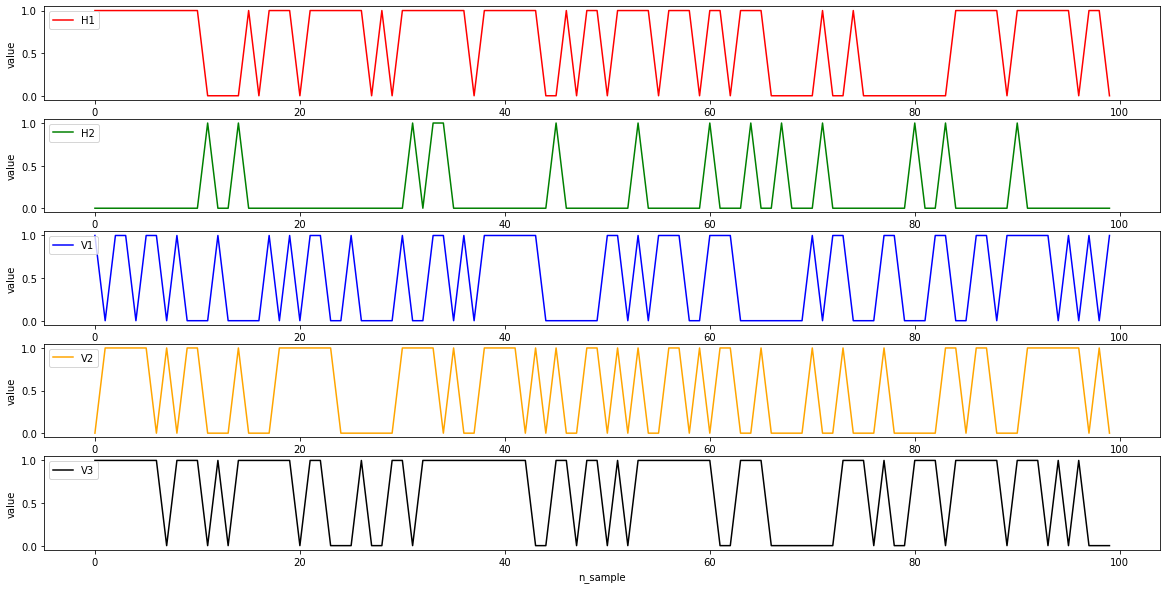

In [6]:
sample_100 = net.gibbs_sampling(observed = np.array([-1, -1, -1, -1, -1,]), num_iterations = 100)
sample_100 = pd.DataFrame(sample_100)
sample_100.columns = ["H1", "H2", "V1", "V2", "V3"]
print("吉布斯采样100次得到的数据点为：")
plt.figure(figsize=(20,10))
plt.subplot(5,1,1)
plt.plot(sample_100.iloc[:,0], color = "red", label = "H1")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.subplot(5,1,2)
plt.plot(sample_100.iloc[:,1], color = "green", label = "H2")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.subplot(5,1,3)
plt.plot(sample_100.iloc[:,2], color = "blue", label = "V1")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.subplot(5,1,4)
plt.plot(sample_100.iloc[:,3], color = "orange", label = "V2")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.subplot(5,1,5)
plt.plot(sample_100.iloc[:,4], color = "black", label = "V3")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.show()

In [7]:
n_samples = 10000
gibbs_samples = net.gibbs_sampling(observed = np.array([-1, -1, -1, -1, -1,]), num_iterations = n_samples)
joint_dist = net.joint_dist()
print("吉布斯采样%d次得到的每个节点的边缘分布为："%(n_samples))
nodes = ["H1", "H2", "V1", "V2", "V3"]
table = []
for i in range(5):
    for value in range(2):
        array = [nodes[i], value]
        array.append(np.where(gibbs_samples[:,i]==value)[0].shape[0]/n_samples)
        array.append(joint_dist.iloc[np.where(joint_dist.iloc[:,i]==value)[0],5].sum())
        array = np.array(array, dtype=object).reshape(1,-1)
        table.append(array)
table=pd.DataFrame(np.concatenate(table, axis=0))
table.columns = ["节点", "取值", "采样得到的边缘分布", "真实边缘分布"]
table

吉布斯采样10000次得到的每个节点的边缘分布为：


,节点,取值,采样得到的边缘分布,真实边缘分布
0,H1,0,0.3993,0.396086
1,H1,1,0.6007,0.603914
2,H2,0,0.7802,0.784246
3,H2,1,0.2198,0.215754
4,V1,0,0.6062,0.601142
5,V1,1,0.3938,0.398858
6,V2,0,0.4871,0.484701
7,V2,1,0.5129,0.515299
8,V3,0,0.4157,0.414986
9,V3,1,0.5843,0.585014


## MHsampling

MH采样100次得到的数据点为：


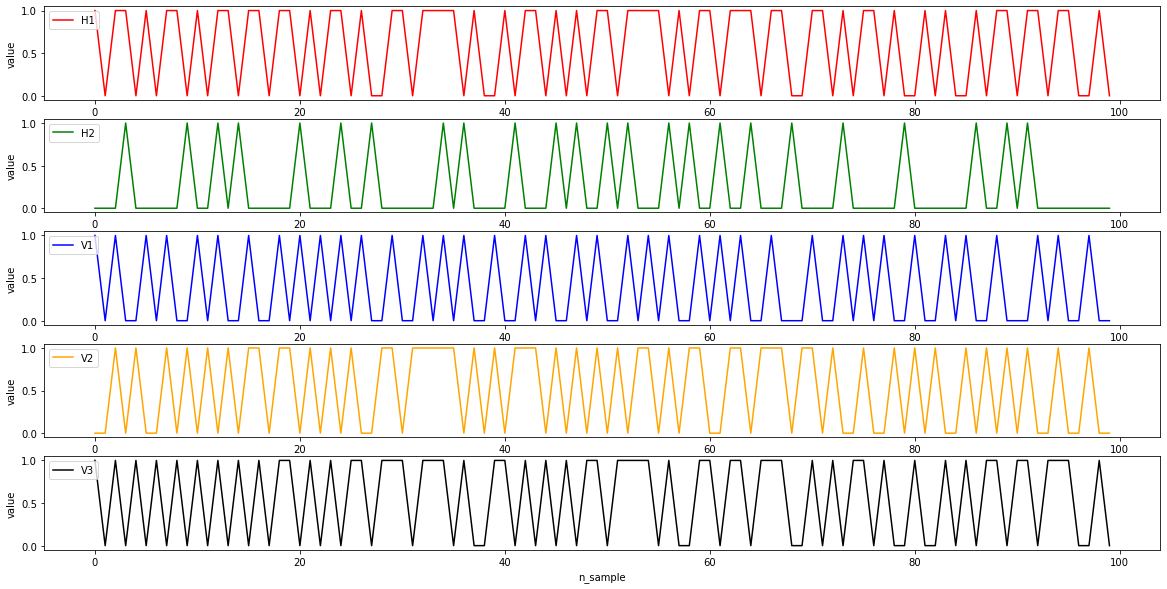

In [8]:
MHsample_100 = net.MH_sampling(num_iterations = 100)
MHsample_100 = pd.DataFrame(MHsample_100)
MHsample_100.columns = ["H1", "H2", "V1", "V2", "V3"]
print("MH采样100次得到的数据点为：")
plt.figure(figsize=(20,10))
plt.subplot(5,1,1)
plt.plot(MHsample_100.iloc[:,0], color = "red", label = "H1")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.subplot(5,1,2)
plt.plot(MHsample_100.iloc[:,1], color = "green", label = "H2")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.subplot(5,1,3)
plt.plot(MHsample_100.iloc[:,2], color = "blue", label = "V1")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.subplot(5,1,4)
plt.plot(MHsample_100.iloc[:,3], color = "orange", label = "V2")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.subplot(5,1,5)
plt.plot(MHsample_100.iloc[:,4], color = "black", label = "V3")
plt.xlabel("n_sample")
plt.ylabel("value")
plt.legend(loc='upper left')
plt.show()

In [9]:
n_samples = 10000
MH_samples = net.MH_sampling(num_iterations = n_samples)
joint_dist = net.joint_dist()
print("MH采样%d次得到的每个节点的边缘分布为："%(n_samples))
nodes = ["H1", "H2", "V1", "V2", "V3"]
table = []
for i in range(5):
    for value in range(2):
        array = [nodes[i], value]
        array.append(np.where(MH_samples[:,i]==value)[0].shape[0]/n_samples)
        array.append(joint_dist.iloc[np.where(joint_dist.iloc[:,i]==value)[0],5].sum())
        array = np.array(array, dtype=object).reshape(1,-1)
        table.append(array)
table=pd.DataFrame(np.concatenate(table, axis=0))
table.columns = ["节点", "取值", "采样得到的边缘分布", "真实边缘分布"]
table

MH采样10000次得到的每个节点的边缘分布为：


,节点,取值,采样得到的边缘分布,真实边缘分布
0,H1,0,0.3949,0.396086
1,H1,1,0.6051,0.603914
2,H2,0,0.7884,0.784246
3,H2,1,0.2116,0.215754
4,V1,0,0.6018,0.601142
5,V1,1,0.3982,0.398858
6,V2,0,0.4796,0.484701
7,V2,1,0.5204,0.515299
8,V3,0,0.4199,0.414986
9,V3,1,0.5801,0.585014


## belief propogation

In [10]:
beliefs, belief_iterations = net.Belief_propagation()

迭代次数为：12次


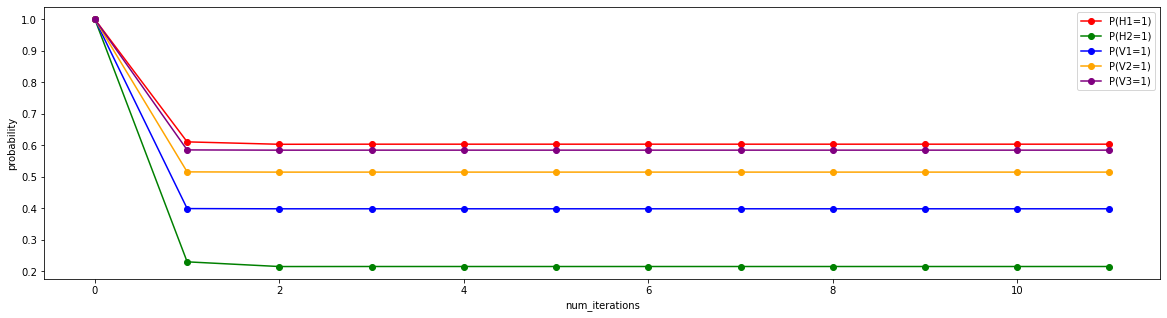

Belief propagation得到的每个节点的边缘分布为：


,节点,取值,BP得到的边缘分布,真实边缘分布
0,H1,0,0.396029,0.396086
1,H1,1,0.603971,0.603914
2,H2,0,0.784402,0.784246
3,H2,1,0.215598,0.215754
4,V1,0,0.601171,0.601142
5,V1,1,0.398829,0.398858
6,V2,0,0.484688,0.484701
7,V2,1,0.515312,0.515299
8,V3,0,0.414948,0.414986
9,V3,1,0.585052,0.585014


In [11]:
print("迭代次数为：%d次"%(belief_iterations.shape[1]))
nodes = ["H1", "H2", "V1", "V2", "V3"]
colors = ["red", "green", "blue", "orange", "purple", "black"]
plt.figure(figsize=(20,5))
for i, iterator in enumerate(belief_iterations):
    plt.plot(iterator, "-o", color=colors[i], label="P("+nodes[i]+"=1)")
plt.xlabel("num_iterations")
plt.ylabel("probability")
plt.legend()
plt.show()

print("Belief propagation得到的每个节点的边缘分布为：")
table = []
for i in range(5):
    for value, prob in enumerate(beliefs[i]):
        array = [nodes[i], value, prob]
        array.append(joint_dist.iloc[np.where(joint_dist.iloc[:,i]==value)[0],5].sum())
        array = np.array(array, dtype=object).reshape(1,-1)
        table.append(array)
table=pd.DataFrame(np.concatenate(table, axis=0))
table.columns = ["节点", "取值", "BP得到的边缘分布", "真实边缘分布"]
table

## Mean filed inference

In [12]:
Q, Q_iterations = net.Mean_field_inference()

迭代次数为：24次


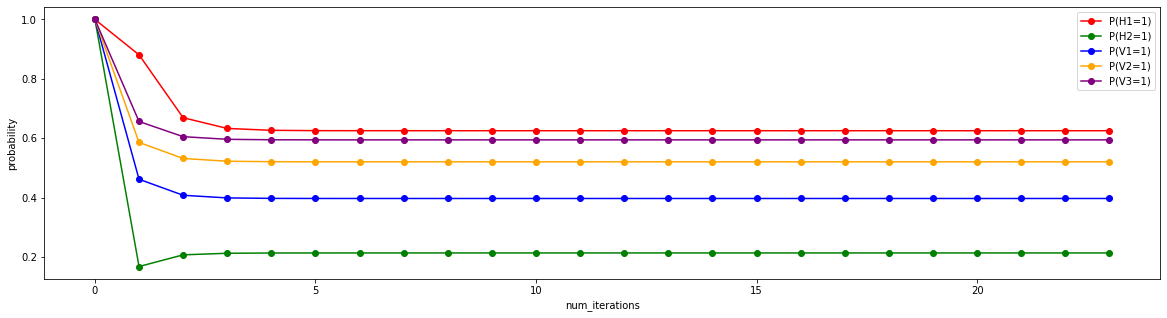

Mean field variational inference得到的每个节点的边缘分布为：


,节点,取值,MFI得到的边缘分布,真实边缘分布
0,H1,0,0.374662,0.396086
1,H1,1,0.625338,0.603914
2,H2,0,0.786248,0.784246
3,H2,1,0.213752,0.215754
4,V1,0,0.602864,0.601142
5,V1,1,0.397136,0.398858
6,V2,0,0.479365,0.484701
7,V2,1,0.520635,0.515299
8,V3,0,0.405503,0.414986
9,V3,1,0.594497,0.585014


In [13]:
print("迭代次数为：%d次"%(Q_iterations.shape[1]))
nodes = ["H1", "H2", "V1", "V2", "V3"]
colors = ["red", "green", "blue", "orange", "purple", "black"]
plt.figure(figsize=(20,5))
for i, iterator in enumerate(Q_iterations):
    plt.plot(iterator, "-o", color=colors[i], label="P("+nodes[i]+"=1)")
plt.xlabel("num_iterations")
plt.ylabel("probability")
plt.legend()
plt.show()

print("Mean field variational inference得到的每个节点的边缘分布为：")
table = []
for i in range(5):
    for value, prob in enumerate(Q[i]):
        array = [nodes[i], value, prob]
        array.append(joint_dist.iloc[np.where(joint_dist.iloc[:,i]==value)[0],5].sum())
        array = np.array(array, dtype=object).reshape(1,-1)
        table.append(array)
table=pd.DataFrame(np.concatenate(table, axis=0))
table.columns = ["节点", "取值", "MFI得到的边缘分布", "真实边缘分布"]
table